In [2]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import glob
import pickle



from skimage import data, img_as_float, io
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim_basic
from skimage.metrics import mean_squared_error
from scipy.ndimage.interpolation import rotate
from skimage.metrics import normalized_root_mse
from tqdm.notebook import tqdm
from scipy import ndimage

import torch
import piq
import os

In [3]:
target = Image.open('DataLoader/philips_15/train/CC0017_philips_15_50_F/lvl83.png').convert('L')

In [4]:
pictures_name = [pict for pict in glob.iglob('DataLoader/siemens_3/train/CC0201_siemens_3_58_F/*.png')]

In [4]:
def create_top_percent_mask(divers, perc, mask_size):
    """ Create a mask, which have 1 only on top 'perc' percents """
    if perc > 0.5:
        print('It is a complete transfer. Check the percentage parameter again.')

    amount = int(mask_size * perc)
    mask = np.zeros_like(divers)
    mask[largest_indices(divers, amount)] = 1
    mask = mask.astype(bool)
    return mask

def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    if n == 0:
        n = 1
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    #     mask = (radius == dist_from_center) or (dist_from_center < (radius + 1))
    mask = np.logical_or(radius == dist_from_center, dist_from_center < (radius + 1))
    return mask

def mask_applying(donor, image, mask, shift=True, phase=False):
    fourier1 = np.fft.fft2(donor)
    fourier2 = np.fft.fft2(image)
                
    if shift:
        fourier1 = np.fft.fftshift(fourier1)
        fourier2 = np.fft.fftshift(fourier2)
    
    image_amp1, image_phase1 = np.absolute(fourier1), np.angle(fourier1)
    image_amp2, image_phase2 = np.absolute(fourier2), np.angle(fourier2)
        
    if phase:
        phase = image_phase1.copy()
        phase[mask == 1] = image_phase2[mask]
        amp = image_amp1 
    else:
        amp = image_amp1.copy()
        amp[mask == 1] = image_amp2[mask]
        phase = image_phase1
    
    
    fourier_image = amp * np.exp(-phase * 1.0j)
    
    if shift:
        fourier_image = np.fft.ifftshift(fourier_image)

    return np.abs(np.fft.ifft2(fourier_image))

In [5]:
def find_nearest_experiment(img_find, pictures_name, with_norm = True, offset = (100, 100)):
    ssim_best_basic = (0, None)
    ssim_best = (0, None)
    mdsi_best = (0, None)
    
    for im in pictures_name:
        donor = io.imread(f'{im}', as_gray = True)
        if with_norm:
            donor = (donor - donor.min()) / donor.max()
            x, y = map(int, ndimage.measurements.center_of_mass(donor))
            donor = donor[x-offset[0]: x+offset[0], y-offset[1] : y+offset[1]]

            if donor.shape[0] * donor.shape[1] == 0:
                continue
                
        mse_cur = mean_squared_error(img_find, donor)
        
        
        x = torch.tensor(torch.from_numpy(donor))[None, None, ...] 
        y = torch.tensor(torch.from_numpy(img_find))[None, None,...]
        ssim_cur = piq.srsim(x, y, data_range=1.) #best one
        
        mdsi_cur = piq.mdsi(x, y, data_range=1., reduction='none') #work good 2
        ssim_cur_basic = ssim_basic(img_find, donor, data_range=1)
        
        if ssim_cur > ssim_best[0]:
            ssim_best = (ssim_cur, im)
            
        if ssim_cur_basic > ssim_best_basic[0]:
            ssim_best_basic = (ssim_cur_basic, im)
            
        if mdsi_cur > mdsi_best[0]:
            mdsi_best = (mdsi_cur, im)
            
    return (ssim_best_basic, ssim_best, mdsi_best)

/tmp/ipykernel_51712/1004692077.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(torch.from_numpy(donor))[None, None, ...]
/tmp/ipykernel_51712/1004692077.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.from_numpy(img_find))[None, None,...]
/home/voland/.local/lib/python3.8/site-packages/piq/mdsi.py:66: UserWarning: The original MDSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original MDSI supports only RGB images. The input images were converted to RGB by copying '


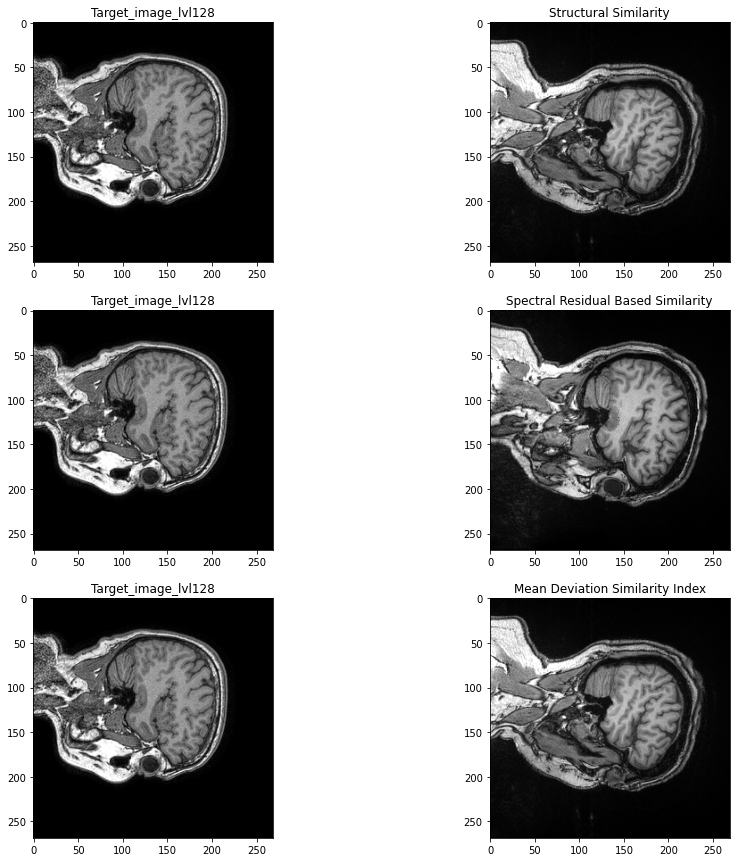

In [6]:
img = io.imread('DataLoader/philips_15/train/CC0017_philips_15_50_F/lvl128.png', as_gray = True)
pictures_name = [pict for pict in glob.iglob('DataLoader/siemens_3/train/CC0201_siemens_3_58_F/*.png')]

img_find = (img - img.min()) / img.max()
x, y = map(int, ndimage.measurements.center_of_mass(img))
img_find = img_find[x-100: x+100, y-100 : y+100]
data_norm = find_nearest_experiment(img_find, pictures_name)

exp_amount = len(data_norm)
f, axarr = plt.subplots(exp_amount, 2, figsize=(15,15))

current_target = 'Target_image_lvl128'
exp_description = ['Structural Similarity', 'Spectral Residual Based Similarity', 
                   'Mean Deviation Similarity Index']

for num, desc in enumerate(exp_description):
    axarr[num][0].set_title(current_target)
    axarr[num][1].set_title(desc)

for i in range(3):
    axarr[i][0].imshow(img, cmap='gray')
    axarr[i][1].imshow(io.imread(data_norm[i][1]), cmap='gray')


In [6]:
def draw_transform(img, data_norm, path_to_pickle, draw_index = 1, rad = 100):
    f, axarr = plt.subplots(1, 5, figsize=(15,15))
    img = resize(img, (300, 300))

    axarr[0].set_title('Target image')
    axarr[0].axis('off')
    axarr[0].imshow(img, cmap='gray')

    x, y = map(int, ndimage.measurements.center_of_mass(img))
    img_norm = img[x-100: x+100, y-100 : y+100]
    img_norm = (img_norm - img_norm.min()) / img_norm.max()

    axarr[1].set_title('Target centerd')
    axarr[1].axis('off')
    axarr[1].imshow(img_norm, cmap='gray')
    
    path_to_founded = data_norm[draw_index][1]
    img_founded = io.imread(path_to_founded)
    img_founded = resize(img_founded, (300, 300))

    
    img_norm_founded = img_founded[x-100: x+100, y-100 : y+100]
    img_norm_founded = (img_norm_founded - img_norm_founded.min()) / img_norm_founded.max()


    
    axarr[2].set_title('Founded normalized')
    axarr[2].axis('off')
    axarr[2].imshow(img_norm_founded, cmap='gray')

    axarr[3].set_title('Basic founded')
    axarr[3].axis('off')
    axarr[3].imshow(img_founded, cmap='gray')

    with open(f'{path_to_pickle}', 'rb') as f:
        domain_diff = pickle.load(f)
        
    print(domain_diff.shape, img_founded.shape)
    mask_w, mask_h = img_founded.shape
    mask = create_circular_mask(mask_w, mask_h, radius=rad)
    domain_diff[np.logical_not(mask)] = 0
    pix_amount = mask.astype(int).sum()
    
    perc = 40
    mask = create_top_percent_mask(domain_diff, 0.0001 * perc, pix_amount)
    print(mask.sum())
    res_image = rotate(mask_applying(img, img_founded, mask), 180)


    axarr[4].set_title('Target fourier changed')
    axarr[4].axis('off')
    axarr[4].imshow(res_image, cmap='gray')



(300, 300) (300, 300)
128


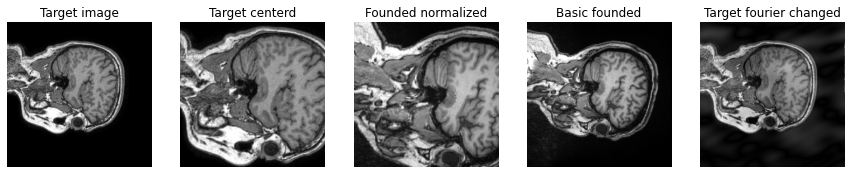

In [8]:
draw_transform(img, data_norm, 'diff_values.pickle')

In [7]:
def prepare_data(path, file_mask = 'png'):
    result = []
    for root, _, files in os.walk(path):
        for name in files:
            if name.endswith(f'.{file_mask}'):
                result.append(os.path.join(root, name))
        else:
            continue
    return result
            

In [31]:
def find_nearest(img, donor_list, with_norm = True, device_name = 'cpu', offset = (100, 100)):
    offset_x, offset_y = offset
    ssim_best = (0, None)
    ssim_list = []
    mse_list = []
    img_find = io.imread(f'{img}', as_gray = True)
    print(img_find.shape)


    if with_norm:
        img_find = (img_find - img_find.min()) / img_find.max()
        x, y = map(int, ndimage.measurements.center_of_mass(img_find))
        img_find = img_find[x-offset_x: x+offset_x, y-offset_y : y+offset_y]
        print(x, y)
        print(img_find.shape)
  
    for im in donor_list:
        donor = io.imread(f'{im}', as_gray = True)
        if with_norm:
            donor = (donor - donor.min()) / donor.max()
            x, y = map(int, ndimage.measurements.center_of_mass(donor))
            print(donor.shape)

            donor = donor[x-offset_x: x+offset_x, y-offset_y : y+offset_y]
            print(donor.shape)
            if donor.shape[0] * donor.shape[1] == 0:
                continue
        
        x = torch.tensor(torch.from_numpy(donor), device = device_name)[None, None, ...] / donor.max()
        print(x.shape)
        if img_find.size == 0 and with_norm:
            print('No data in image(not enough data-pixels), resizing window:')
            return find_nearest(img, donor_list, with_norm = True, offset = (offset[0]-3, offset[0] - 3))
                                
        y = torch.tensor(torch.from_numpy(img_find), device = device_name)[None, None,...] / img_find.max()
        ssim_cur = piq.srsim(x, y, data_range=1.) #best one


        ssim_best = (ssim_cur, im) if ssim_cur > ssim_best[0] else ssim_best
            
            
    return ssim_best[1]

In [46]:
import time
start_time = time.time()
data = prepare_data('DataLoader/philips_15X/train/CC0001_philips_15_55_M/')
x = find_nearest('DataLoader/ge_3X/train/CC0301_ge_3_53_F/lvl63.png', data, with_norm = True, offset = (90, 90))
print("--- %s seconds ---" % (time.time() - start_time))

(185, 256)
89 115
(0, 180)
(180, 256)
(179, 180)
torch.Size([1, 1, 179, 180])
No data in image(not enough data-pixels), resizing window:
(185, 256)
89 115
(174, 174)
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)


/tmp/ipykernel_8217/1539977307.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(torch.from_numpy(donor), device = device_name)[None, None, ...] / donor.max()
/tmp/ipykernel_8217/1539977307.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.from_numpy(img_find), device = device_name)[None, None,...] / img_find.max()


torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(180, 256)
(174, 174)
torch.Size([1, 1, 174, 174])
(1

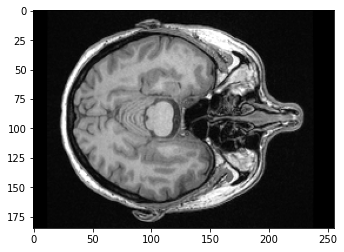

In [48]:
plt.imshow(io.imread('DataLoader/ge_3X/train/CC0301_ge_3_53_F/lvl63.png'), cmap = 'gray')

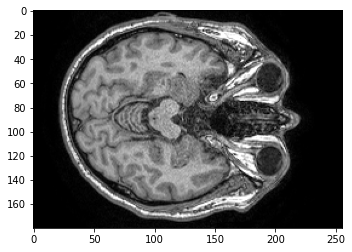

In [49]:
plt.imshow(io.imread(x), cmap = 'gray')

In [24]:
def create_circular(h, w, max_numb = None, center=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if max_numb is None:
        max_numb = np.sqrt((int(h/2))**2 + int((w/2))**2)
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt(abs((X - center[0])**2 + (Y - center[1])**2))

    print(dist_from_center)
    print(max_numb - dist_from_center)
    return dist_from_center, max_numb - dist_from_center

create_circular(3, 2)

[[1.41421356 1.        ]
 [1.         0.        ]
 [1.41421356 1.        ]]
[[0.         0.41421356]
 [0.41421356 1.41421356]
 [0.         0.41421356]]


(array([[1.41421356, 1.        ],
        [1.        , 0.        ],
        [1.41421356, 1.        ]]),
 array([[0.        , 0.41421356],
        [0.41421356, 1.41421356],
        [0.        , 0.41421356]]))